In [2]:
from datetime import datetime
import paho.mqtt.client as mqtt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import median_abs_deviation

# detection of faults based on deviation from MAD of a segment
def detect(longitude, latitude):
    outlier_idx = []
    factor = 5.5    # multiplier for MAD
    step = 10       # path segment size
    for i in range(0, len(latitude), step):
        if i+step > len(latitude):
            latitude_subset = latitude[i:len(latitude)]
            longitude_subset = longitude[i:len(latitude)]
        else:
            latitude_subset = latitude[i:i+step]
            longitude_subset = longitude[i:i+step]
        latitude_mad = median_abs_deviation(latitude_subset)
        longitude_mad = median_abs_deviation(longitude_subset)
        for j in range(len(latitude_subset)):
            if (np.abs(latitude_subset[j] - np.median(latitude_subset)) > factor * latitude_mad 
                or
                np.abs(longitude_subset[j] - np.median(longitude_subset)) > factor * longitude_mad):
                outlier_idx.append(i+j)
    return outlier_idx

def overlapping_ouliers(outliers1, outliers2):
    overlapping=[]
    for elem in outliers1:
        if elem in (outliers2):
            overlapping.append(elem)
    overlapping=np.array(overlapping)
    return overlapping 

# redundancy-based on 2 paths
def reconstruct(longitude, latitude, longitude2, latitude2, outlier_idx, outlier_idx2):
    overlapping = overlapping_ouliers(outlier_idx, outlier_idx2)
    longitude3 = longitude[:]
    latitude3 = latitude[:]
    for i in range(len(longitude)):
        if i in outlier_idx and (i not in overlapping):
            longitude3[i] = longitude2[i]
            latitude3[i] = latitude2[i]

    for j in reversed(overlapping):
        longitude3.pop(j)
        latitude3.pop(j)
        
    return longitude3, latitude3


Connected to MQTT Broker


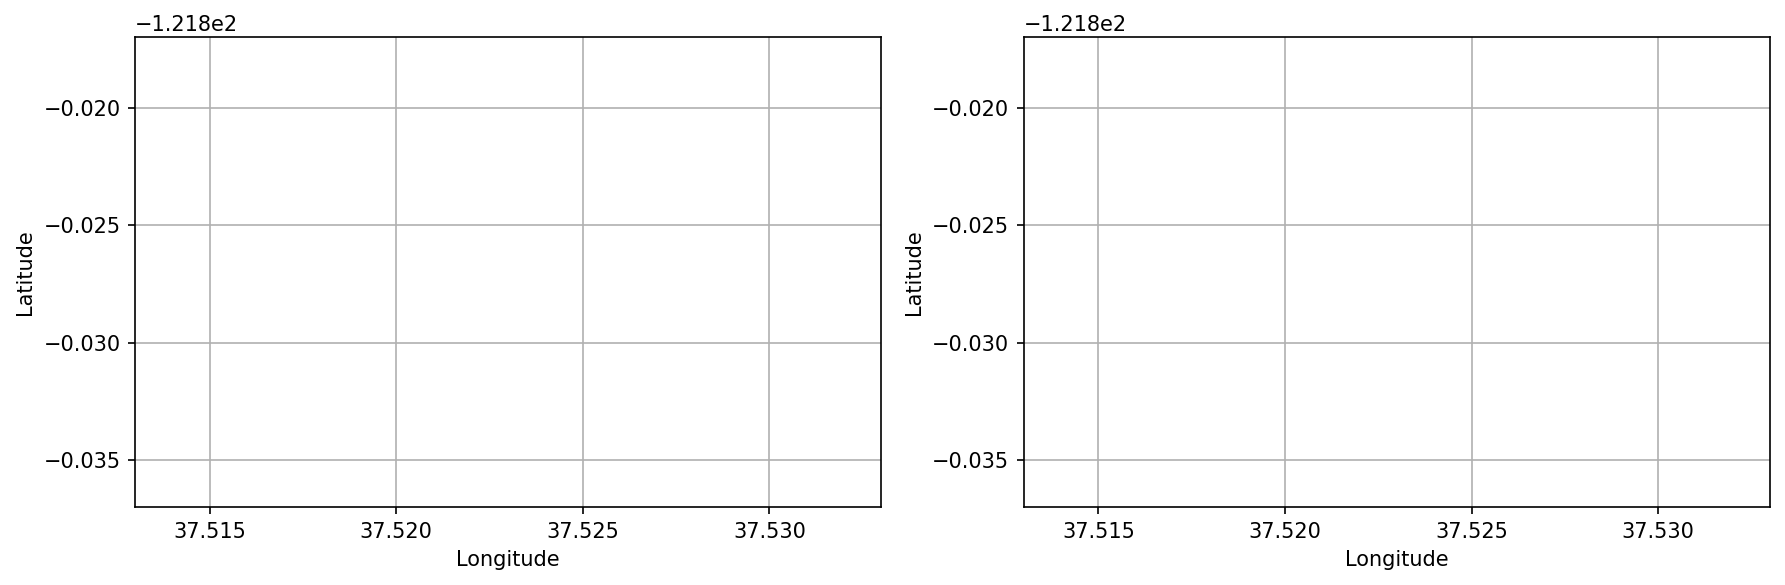

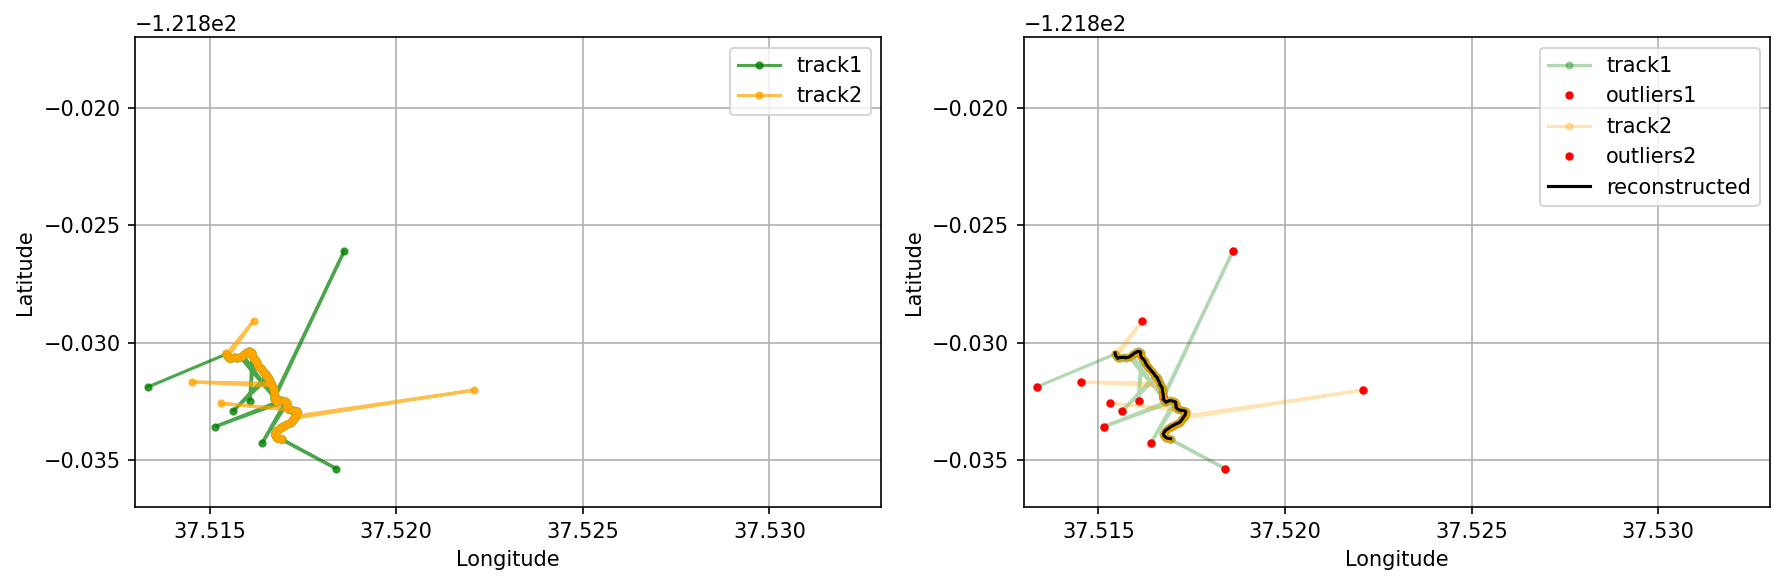

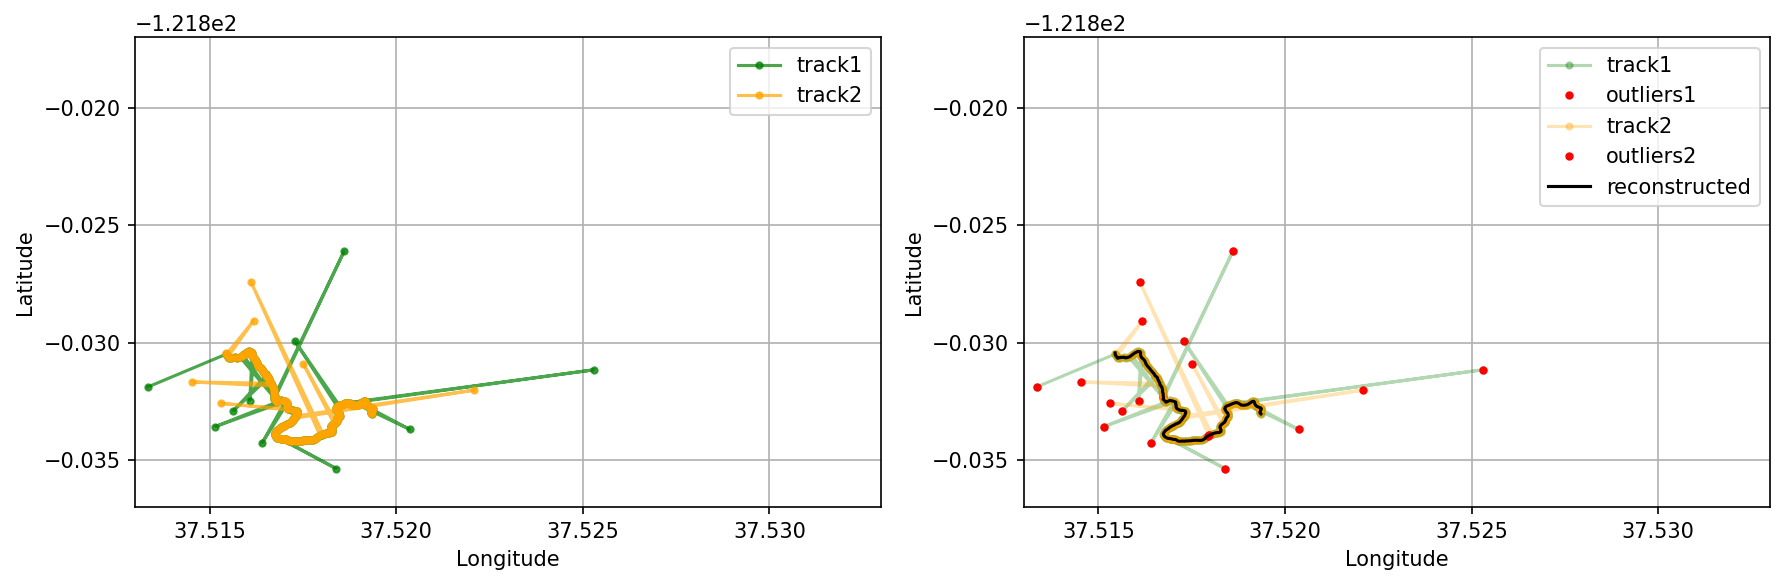

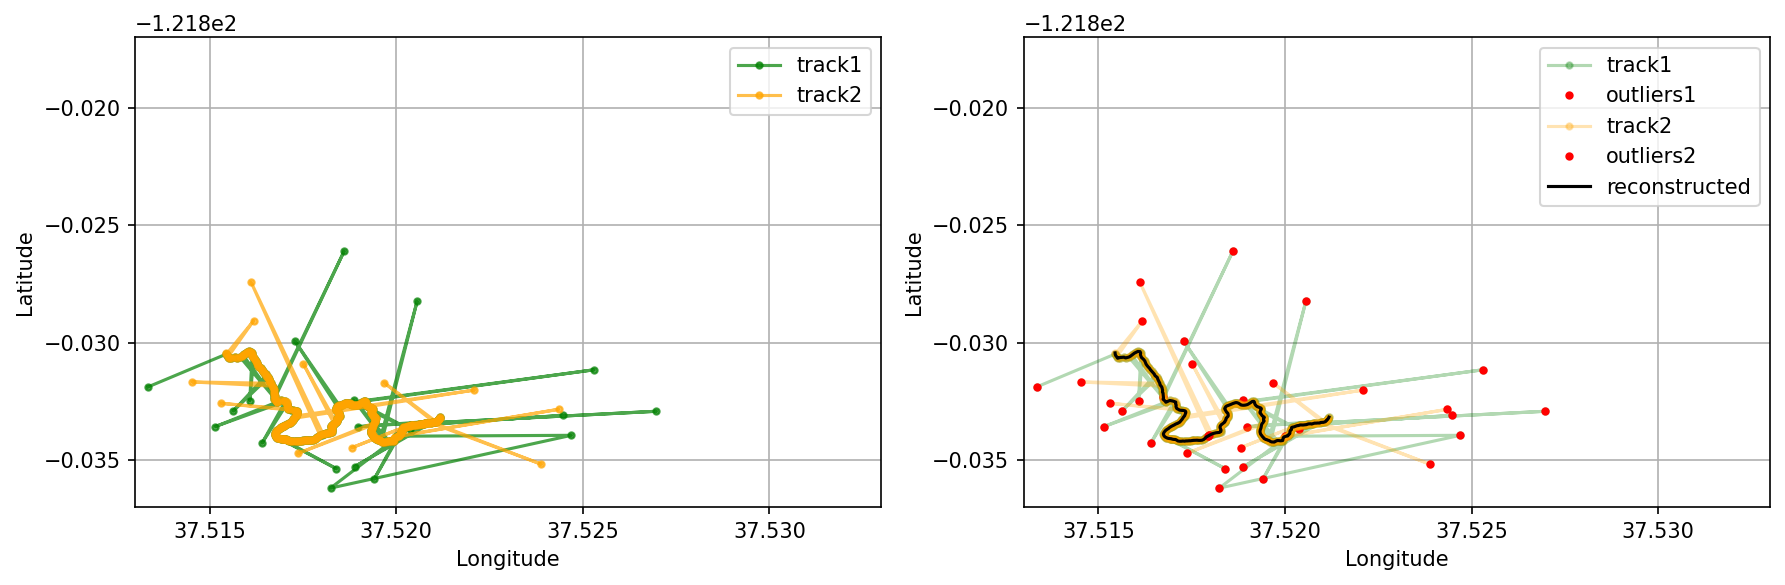

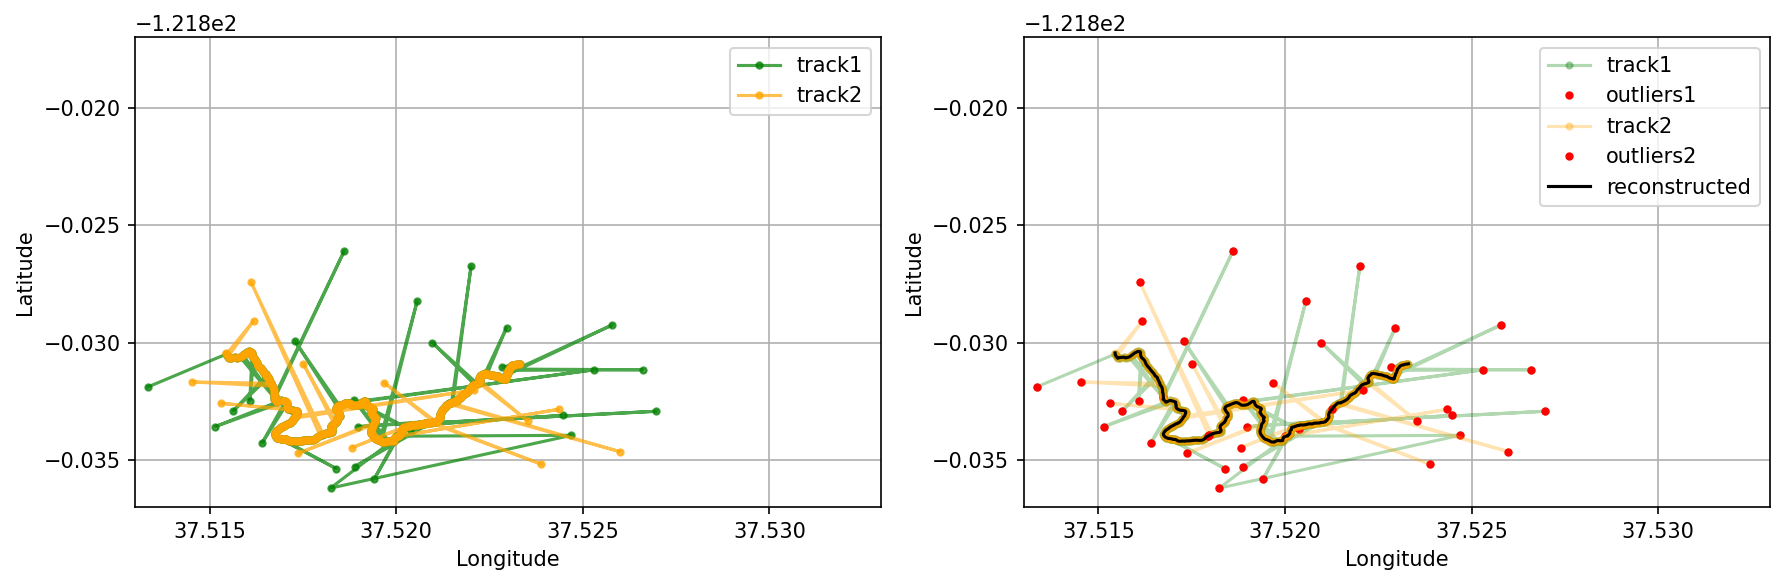

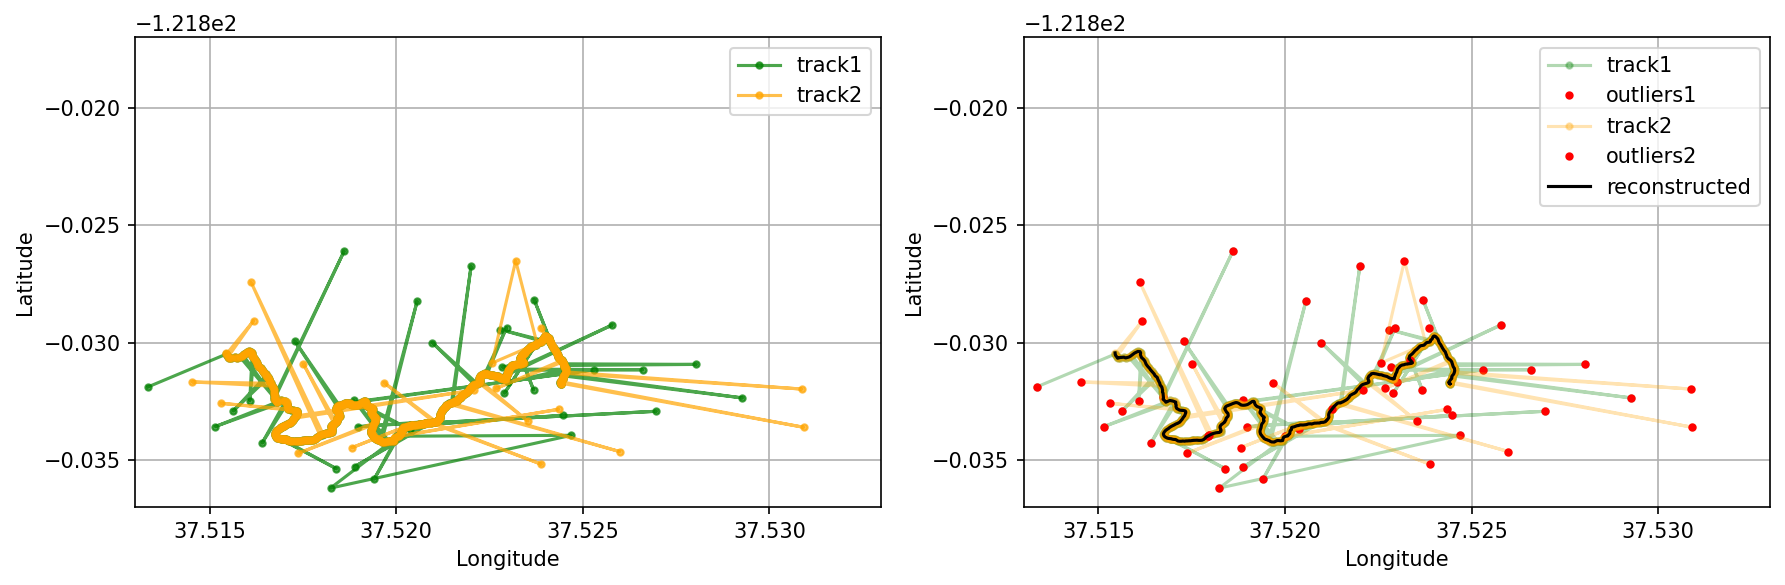

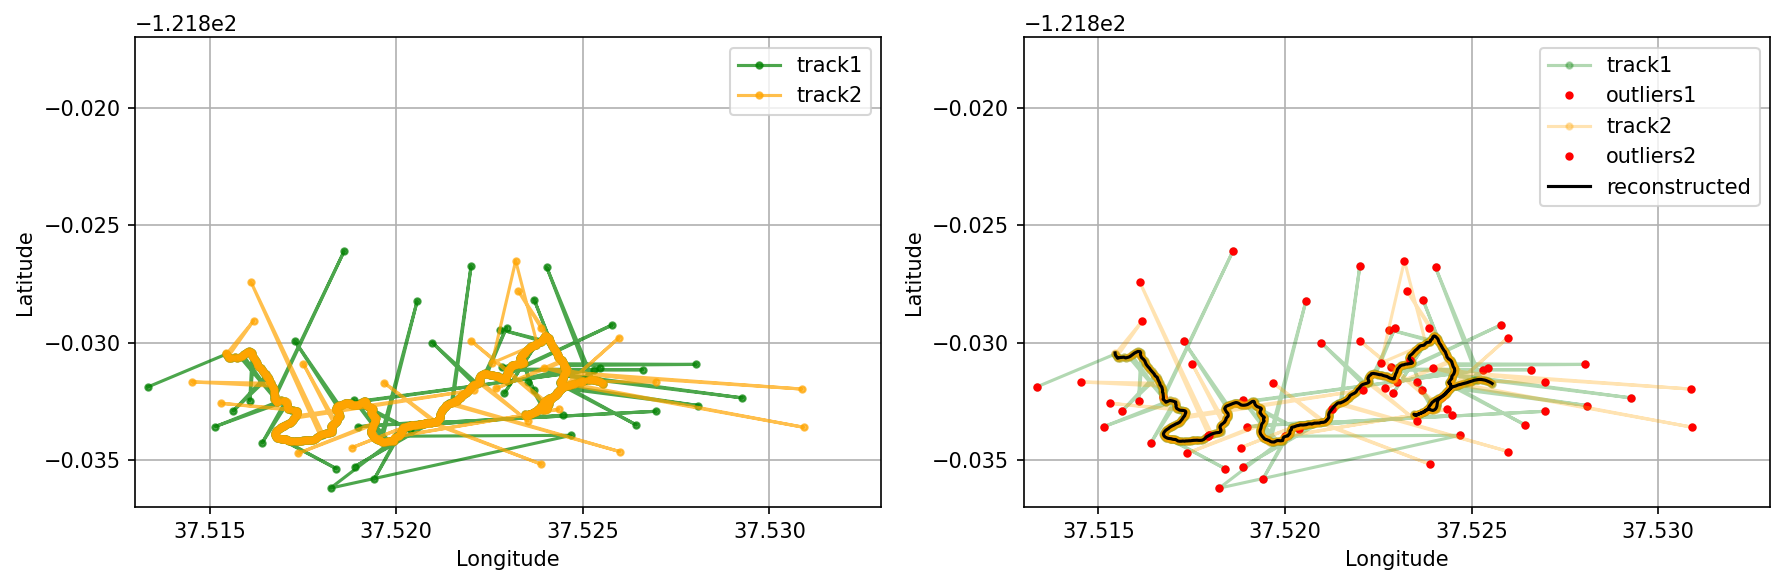

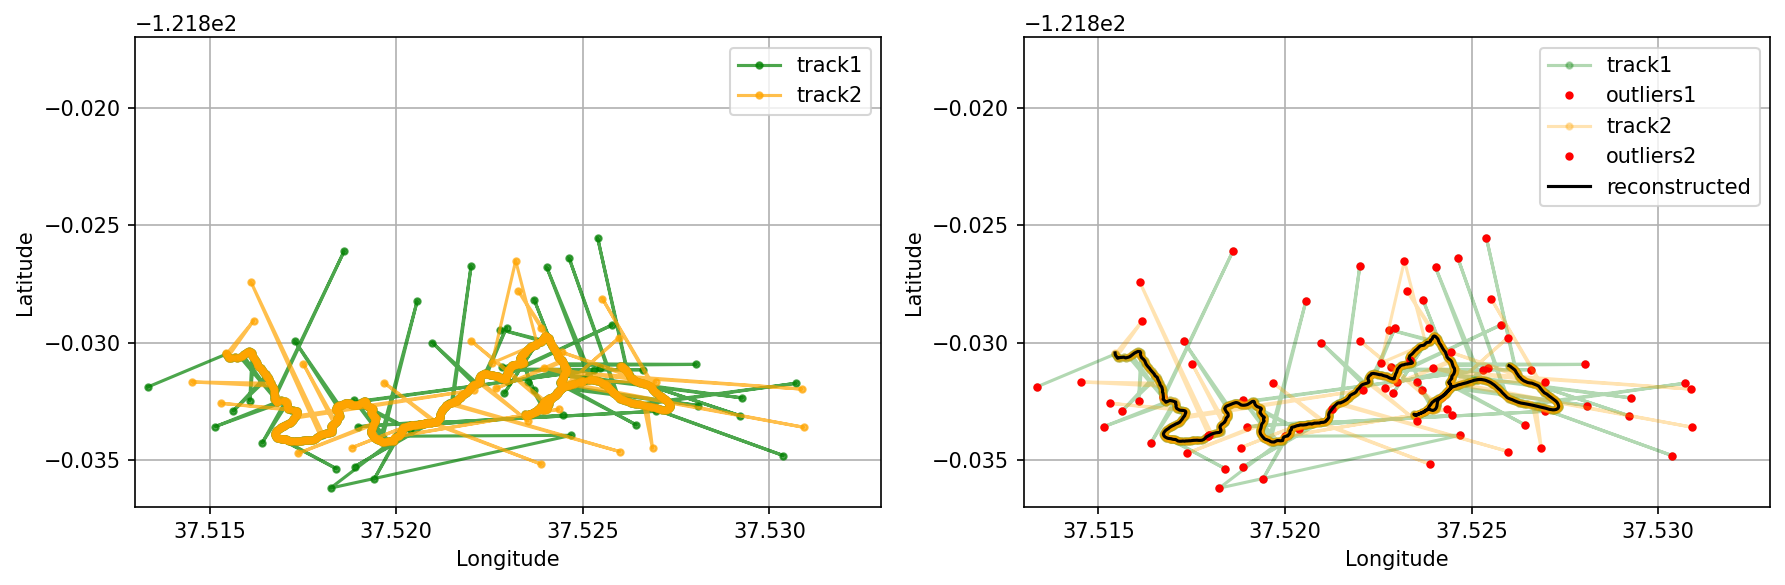

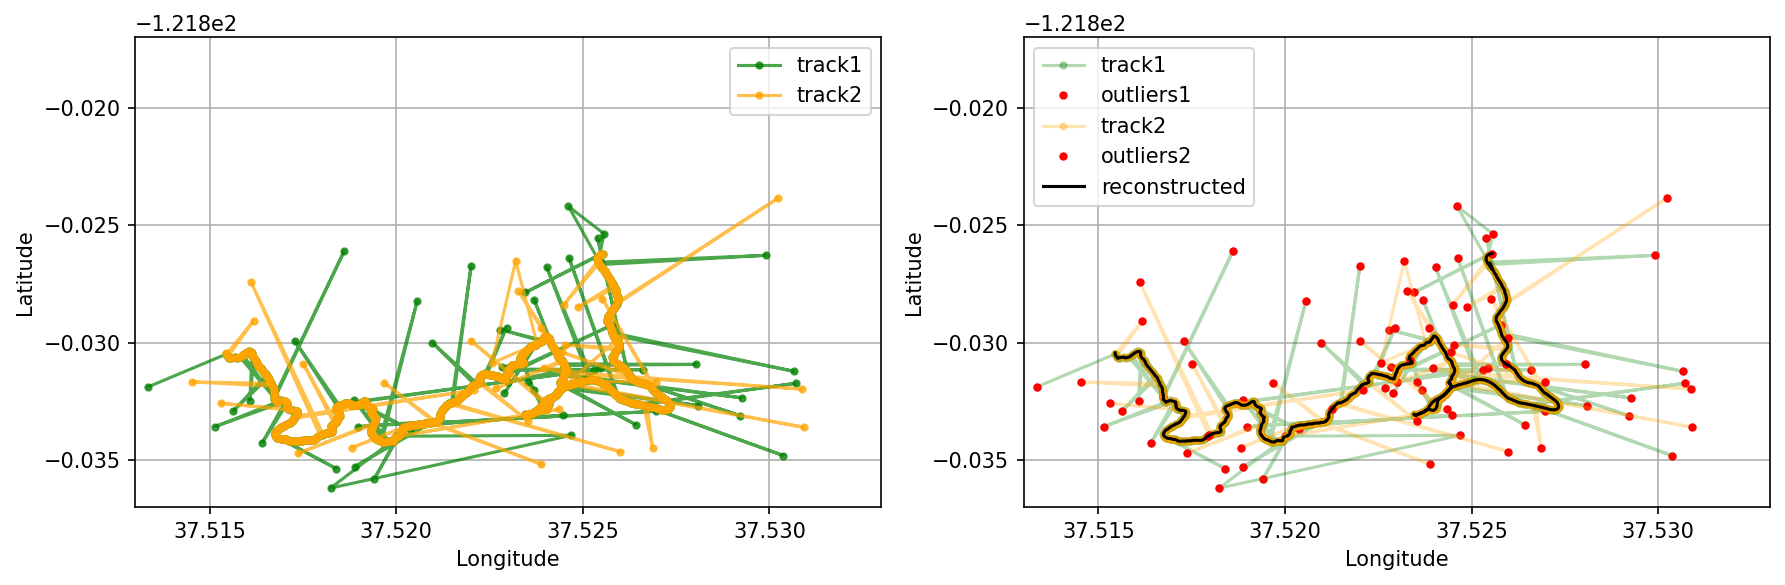

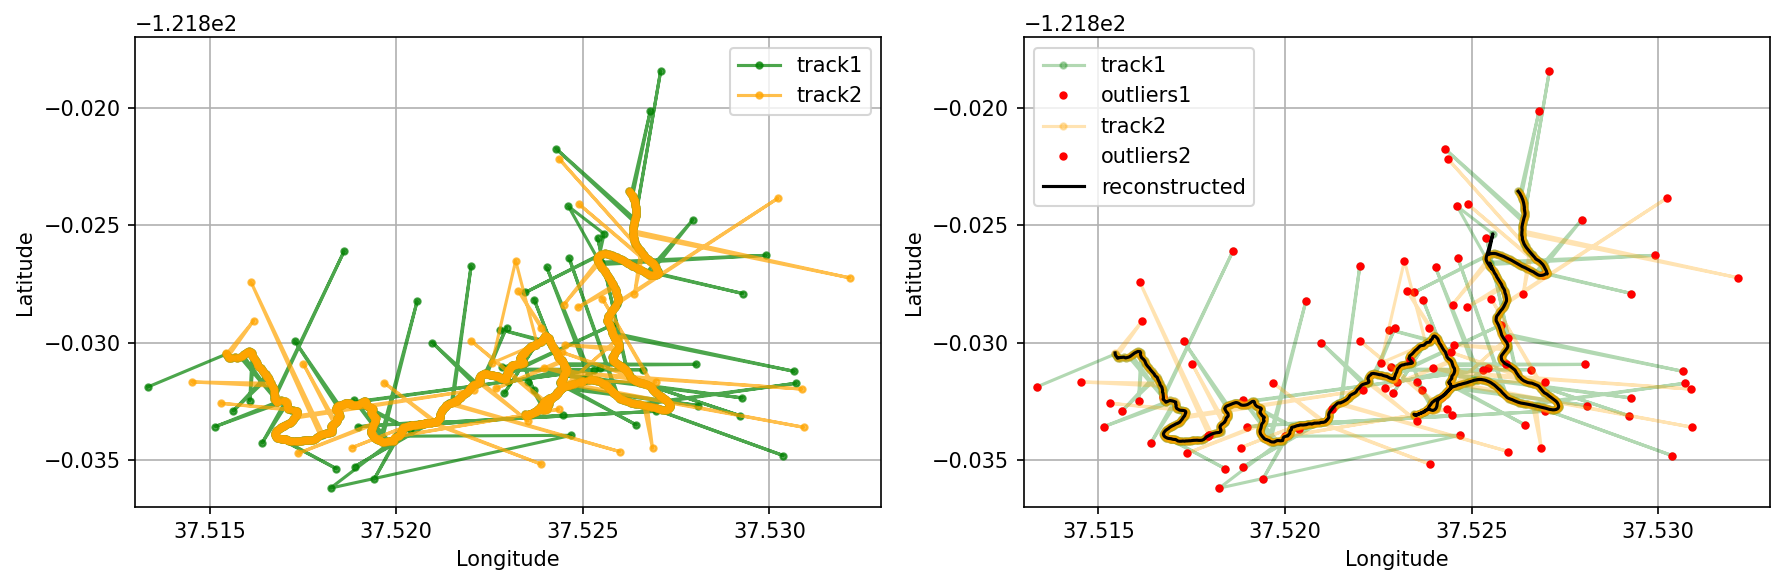

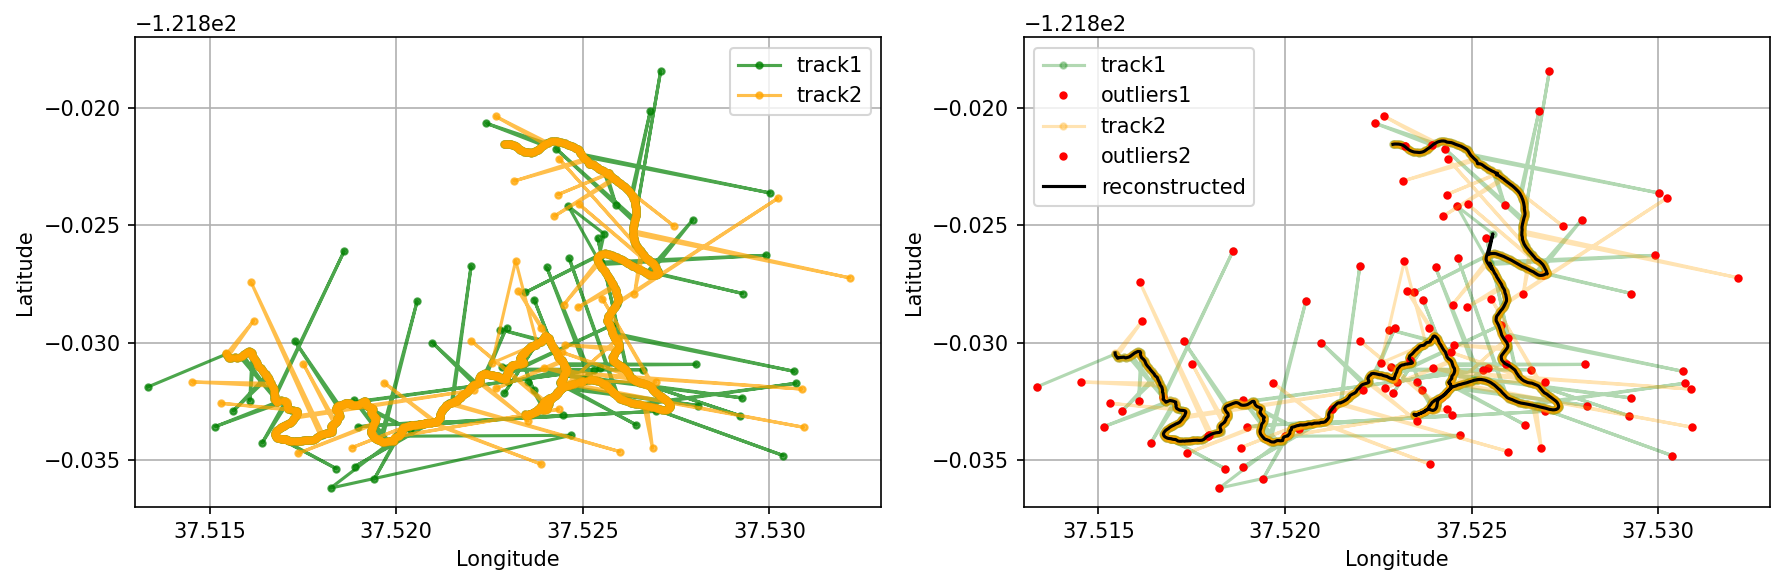

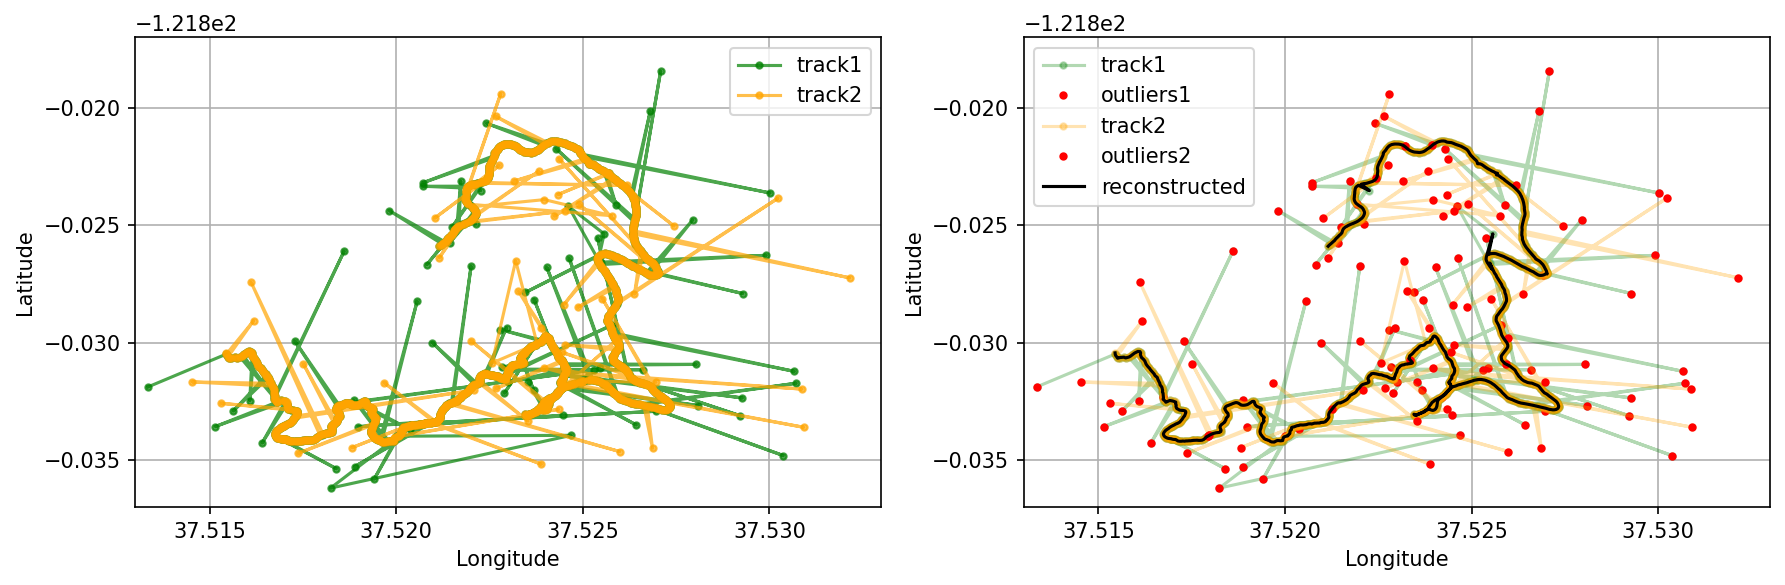

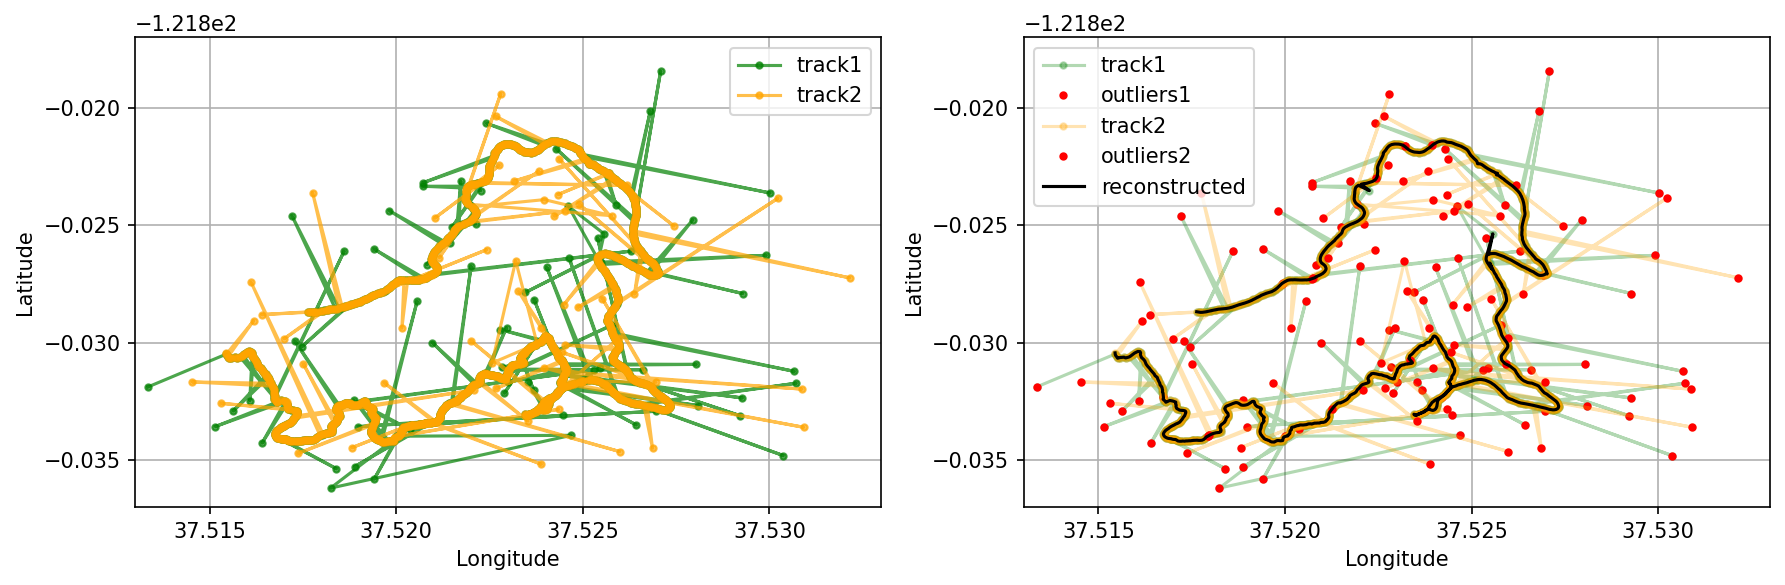

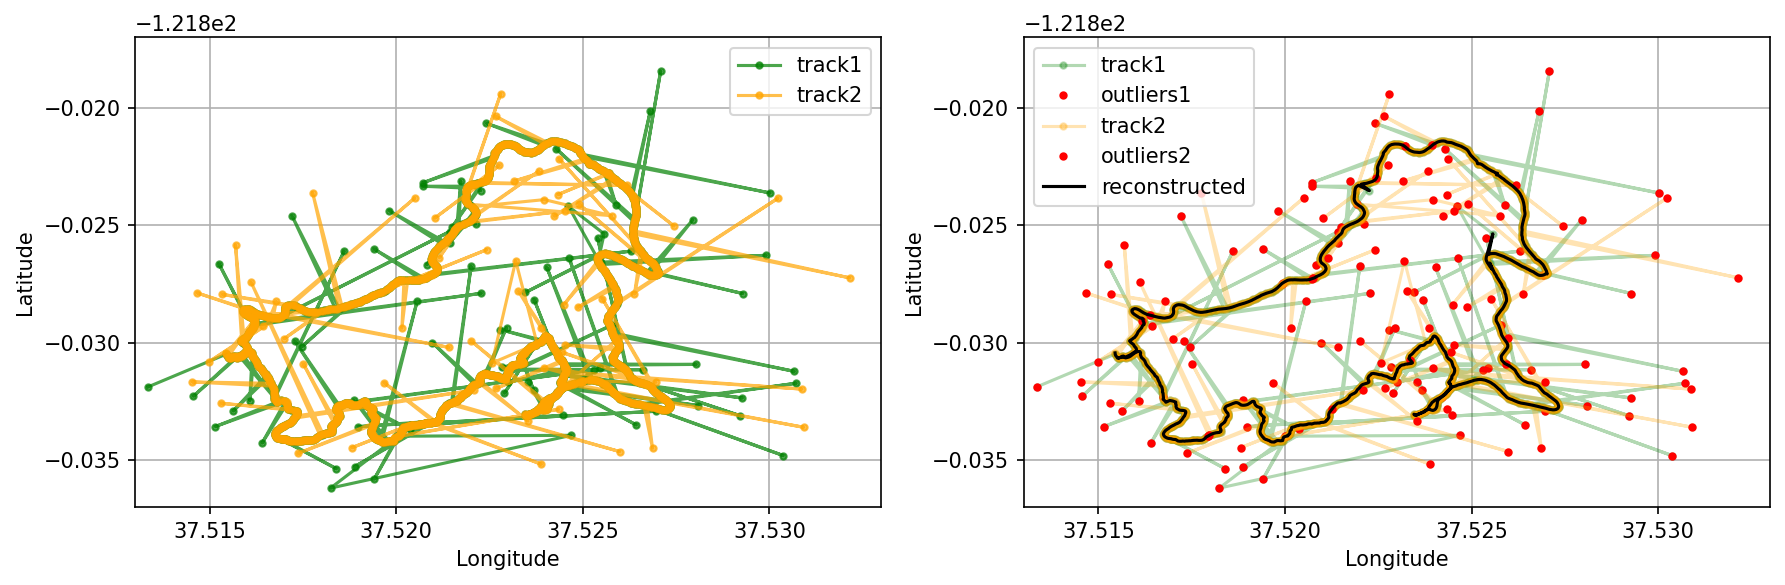

KeyboardInterrupt: 

In [17]:
global time, longitude, longitude2, latitude,  latitude2, elevation
time = []
longitude = []
longitude2 = []
latitude = []
latitude2 = []
elevation = []

def plot_frame():
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
    zoom_pos = [37.523, -121.827]
    zoom_spread = [1e-2, 1e-2]
    ticks_y = -121.8 - np.array([0.035, 0.03, 0.025, 0.020])
    ticks_x = 37.5 + np.array([0.015, 0.02, 0.025, 0.03])
    for a in ax:
        a.set_ylim([zoom_pos[1]-zoom_spread[1], zoom_pos[1]+zoom_spread[1]])
        a.set_xlim([zoom_pos[0]-zoom_spread[0], zoom_pos[0]+zoom_spread[0]])
        a.set_yticks(ticks_y)
        a.set_xticks(ticks_x)
        a.set_ylabel('Latitude')
        a.set_xlabel('Longitude')
        a.grid()
    plt.tight_layout()
    plt.show()

def append_data(message):
    parts = message.split()
    time.append(datetime.strptime(parts[0]+' '+parts[1], '%Y-%m-%d %H:%M:%S%z'))
    longitude.append(float(parts[2]))
    longitude2.append(float(parts[3]))
    latitude.append(float(parts[4]))
    latitude2.append(float(parts[5]))
    elevation.append(float(parts[6]))

def run_subscriber():
    # Callback function that runs when the client connects to the broker
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker")
            client.subscribe("the_topic/#")  # The topic to publish to
            plot_frame()
        else:
            print("Failed to connect, return code:", rc)

    # Callback function that runs when a new message is received
    def on_message(client, userdata, msg):
        message = msg.payload.decode()
        append_data(message)
        
        # plot upon receival of 101 nodes
        if len(longitude)%101 == 0:     
            outlier_idx = detect(longitude, latitude)
            outlier_idx2 = detect(longitude2, latitude2)
            longitude3, latitude3 = reconstruct(longitude, latitude, longitude2, latitude2, outlier_idx, outlier_idx2)
            
            fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
            ax[0].plot(longitude, latitude, label='track1', color='green', linestyle='-', marker='.', alpha=0.7)
            ax[0].plot(longitude2, latitude2, label='track2', color='orange', linestyle='-', marker='.', alpha=0.7)

            ax[1].plot(longitude, latitude, label='track1', color='green', linestyle='-', marker='.', alpha=0.3)
            ax[1].plot(longitude, latitude, label='outliers1', color='red', linestyle='None', marker='.', markevery=outlier_idx)
            ax[1].plot(longitude2, latitude2, label='track2', color='orange', linestyle='-', marker='.', alpha=0.3)
            ax[1].plot(longitude2, latitude2, label='outliers2', color='red', linestyle='None', marker='.', markevery=outlier_idx2)
            ax[1].plot(longitude3, latitude3, label='reconstructed', color='black', linestyle='-', marker='None', alpha=1)

            zoom_pos = [37.523, -121.827]
            zoom_spread = [1e-2, 1e-2]
            ticks_y = -121.8 - np.array([0.035, 0.03, 0.025, 0.020])
            ticks_x = 37.5 + np.array([0.015, 0.02, 0.025, 0.03])
            for a in ax:
                a.set_ylim([zoom_pos[1]-zoom_spread[1], zoom_pos[1]+zoom_spread[1]])
                a.set_xlim([zoom_pos[0]-zoom_spread[0], zoom_pos[0]+zoom_spread[0]])
                a.set_yticks(ticks_y)
                a.set_xticks(ticks_x)
                a.set_ylabel('Latitude')
                a.set_xlabel('Longitude')
                a.legend(loc='best')
                a.grid()
                
            plt.tight_layout()
            plt.show()
        
    # Create an MQTT client instance and assign callbacks
    client = mqtt.Client()
    client.on_connect = on_connect
    client.on_message = on_message
    
    # Connect to the MQTT broker and start the MQTT network loop
    broker_address = "localhost"  
    broker_port = 1883
    client.connect(broker_address, broker_port, 60)
    client.loop_forever()

run_subscriber()

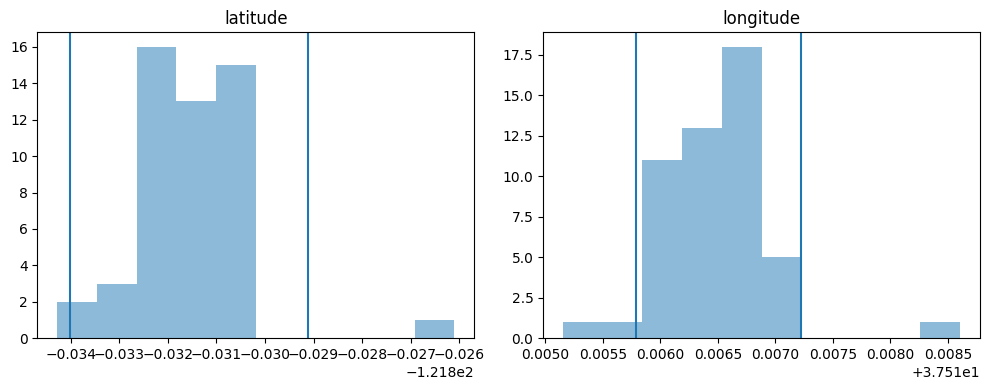

In [18]:
# Histograms to adjust (play with) factor for MAD 

st = 10
en = st + 50
latitude_seg = latitude[st:en]
longitude_seg = longitude[st:en]

factor = 3
if 1:
    
    mad_lat = median_abs_deviation(latitude_seg) * factor
    m_lat = np.median(latitude_seg)
    mad_lon = median_abs_deviation(longitude_seg) * factor
    m_lon = np.median(longitude_seg)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].hist(latitude_seg, alpha=0.5)
    axs[0].axvline(m_lat + mad_lat)
    axs[0].axvline(m_lat - mad_lat)
    axs[0].set_title('latitude')

    axs[1].hist(longitude_seg, alpha=0.5)
    axs[1].axvline(m_lon + mad_lon)
    axs[1].axvline(m_lon - mad_lon)
    axs[1].set_title('longitude')
    plt.tight_layout()
    plt.show()